# Exploring UC1004 dataset

In [1]:
import sys
sys.path.insert(0, './utils/')

import geo_conv
import sqlite3 as sqlite
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from scipy.io import mmwrite, mmread
import scipy.spatial.distance
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import train_test_split
import folium
import datetime
import os

plt.style.use('ggplot')
%matplotlib inline

Database schema: network, us_pos, us_signal

In [6]:
def add_lat_lon(df):
    xy = zip(df.x.values, df.y.values)
    latlon = map(lambda (coord):geo_conv.convert_GK_to_lat_long(coord[0]+__XMIN, coord[1]+__YMIN), xy)
    
    if 'lat' not in df.columns:
        df = pd.concat([df, 
                        pd.DataFrame.from_records(latlon, columns=['lat', 'lon'])],
                       axis=1)
    else:
        df[['lat', 'lon']] = pd.DataFrame.from_records(latlon, columns=['lat', 'lon'])
        
    return df


def bs_mean(vector, num_samples, conf):
    boot_sample = np.zeros_like(vector)
    boot_means = np.zeros((num_samples))
    for s in xrange(num_samples):
        boot_sample = np.random.choice(vector,
                               replace=True)
        boot_means[s] = boot_sample.mean()
    boot_means.sort()
    return np.percentile(boot_means, [(100-conf)/2, (100+conf)/2])

In [3]:
np.random.seed(1)
__CITY_LAT = 52.3667
__CITY_LON = 9.7167
__XMIN = 4336000
__YMIN = 5794000
__LOAD_TRAIN_TEST_MATRIX = 0
__TRAIN_TEST_DATE = ''
__M_FILE_FOLDER = os.path.join('.', 'data', 'uc1004', 'mmfiles')
__DATE = '_' + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

In [4]:
# Check if folder with outputs exists
if not os.path.exists(__M_FILE_FOLDER):
    os.makedirs(__M_FILE_FOLDER)

In [5]:
# Setting conntection to sqlite db
if os.path.exists(os.path.join('.', 'data', 'uc1004', 'uc1004.db')):
    conn = sqlite.connect('./data/uc1004/uc1004.db')

## Getting Networkd data

In [23]:
# Get Network data file
query = 'SELECT * FROM network;'

network = pd.read_sql(query, conn)
network.shape

(195, 11)

In [24]:
network = add_lat_lon(network)
network.set_index('cell_id', inplace=True)
network.head(10)

,x,y,z,azimuth,tilt,transmit_pwr,type,eirp,bandwidth,centr_freq,lat,lon
cell_id,,,,,,,,,,,,
1,11980.62,9511.46,18,100,4,46,Kathrein 742212,63.5,10,1810,52.343905,9.767655
2,11976.05,9511.91,18,220,4,46,Kathrein 742212,63.5,10,1810,52.343908,9.767588
3,11974.14,9521.92,18,340,4,46,Kathrein 742212,63.5,10,1810,52.343998,9.767555
4,11327.24,14888.51,25,60,4,46,Kathrein 742212,63.5,10,1810,52.392010,9.755628
5,11327.24,14888.51,25,180,4,46,Kathrein 742212,63.5,10,1810,52.392010,9.755628
6,11327.24,14888.51,25,300,4,46,Kathrein 742212,63.5,10,1810,52.392010,9.755628
7,11874.95,12539.22,29,10,4,46,Kathrein 742212,63.5,10,1810,52.371065,9.764733
8,11876.16,12536.20,29,130,4,46,Kathrein 742212,63.5,10,1810,52.371039,9.764753
9,11872.84,12536.20,29,250,4,46,Kathrein 742212,63.5,10,1810,52.371038,9.764704


## Getting User Position

As it goes from the article, users are categorized to:<br\>
Vehicular: 0 ... 4619 <br\>
Pedestrian: 10000 ... 15246<br\>
Static Indoor: 20000 ... 29999

In [25]:
user_id = 10003
query = 'SELECT * FROM us_pos INDEXED BY user_index WHERE userid=%d' % user_id
user_pos = pd.read_sql(query, conn)

In [26]:
print user_pos.shape
user_pos.sort_values('time', inplace=True)
user_pos.head()

(14753, 5)


,time,userid,x,y,z
0,0.1,10003,9842.16,14497.20,1.5
1,0.2,10003,9842.03,14497.23,1.5
2,0.3,10003,9841.89,14497.27,1.5
3,0.4,10003,9841.75,14497.30,1.5
4,0.5,10003,9841.62,14497.33,1.5


In [27]:
# Adding lat, long columns
user_pos = add_lat_lon(user_pos)
user_pos.head()

,time,userid,x,y,z,lat,lon
0,0.1,10003,9842.16,14497.20,1.5,52.388080,9.734010
1,0.2,10003,9842.03,14497.23,1.5,52.388080,9.734008
2,0.3,10003,9841.89,14497.27,1.5,52.388080,9.734006
3,0.4,10003,9841.75,14497.30,1.5,52.388080,9.734004
4,0.5,10003,9841.62,14497.33,1.5,52.388081,9.734002


## Getting User's RSPS

In [28]:
query = 'SELECT * FROM us_signal INDEXED BY user_index_sig WHERE userid=%d' % user_id
user_signals = pd.read_sql(query, conn)

In [29]:
print user_signals.shape
user_signals.sort_values('time', inplace=True)
user_signals.head()

(14753, 42)


,time,userid,cell_id1,rsr1,cell_id2,rsr2,cell_id3,rsr3,cell_id4,rsr4,...,cell_id16,rsr16,cell_id17,rsr17,cell_id18,rsr18,cell_id19,rsr19,cell_id20,rsr20
0,0.1,10003,23,-64.70,138,-65.82,91,-65.90,187,-67.62,...,183,-79.48,21,-81.15,15,-81.61,136,-81.87,140,-81.88
1,0.2,10003,23,-64.71,138,-65.82,91,-65.91,187,-67.73,...,183,-79.48,21,-81.21,15,-81.65,140,-81.85,136,-81.87
2,0.3,10003,23,-64.72,91,-65.87,138,-65.88,187,-67.78,...,183,-79.48,21,-81.23,15,-81.66,140,-81.86,136,-81.92
3,0.4,10003,23,-64.72,91,-65.87,138,-65.87,187,-67.83,...,183,-79.49,21,-81.26,15,-81.69,140,-81.84,136,-81.92
4,0.5,10003,23,-64.72,91,-65.87,138,-65.87,187,-67.93,...,183,-79.49,21,-81.31,15,-81.73,140,-81.82,136,-81.92


In [30]:
# Identify cell set for user
cell_id_cols = range(2, 42, 2)
cell_ids = np.unique(user_signals.iloc[:, cell_id_cols].values.astype(int))

## Plotting Maps From Dataset

### Land-case map

In [ ]:
# Land-case map
use_map = np.genfromtxt('./data/uc1004/Land_Use_Map.csv', delimiter=';')

In [ ]:
print use_map.shape # It differes from info in the article
print np.unique(use_map)

In [ ]:
# .T to have refference with pics in the article
# But map shoulb be rotated by 90 degrees (according to google maps)
# Moreover, the map in data is not the same as in the article..
# fig = plt.figure(figsize=(10, 20))
# plt.imshow(use_map.T, cmap='flag')

In [ ]:
use_map = np.rot90(use_map)

In [ ]:
fig = plt.figure(figsize=(10, 20))
plt.imshow(use_map, cmap='flag')

### Best server map

In [ ]:
best_server = np.genfromtxt('./data/uc1004/Best_Server_Map.csv', delimiter=';')

In [ ]:
print best_server.shape # It differes from info in the article
print np.unique(best_server) # should be at least = to # of cells

In [ ]:
best_server = np.rot90(best_server)

In [ ]:
fig = plt.figure(figsize=(10, 20))
plt.imshow(best_server, cmap='flag')

## Generating map with user route and cell positions

In [ ]:
map_hannover = folium.Map(location=[__CITY_LAT, __CITY_LON], 
                          zoom_start=15)
map_hannover.line(locations=user_pos[['lat', 'lon']].values,
                  line_opacity=0.5, 
                  popup=('user: ' + str(user_id)))
for cid in cell_ids:
    cell = network.loc[cid]
    map_hannover.polygon_marker(location=[cell.lat, cell.lon],
                                num_sides=3,
                                radius=5,
                                rotation=cell.azimuth,
                                popup='cell_id: ' + str(cid) + '\nazimuth: ' + str(cell.azimuth))

map_hannover.create_map(path='./data/uc1004/map.html')

## Generating map with all cells

In [61]:
map_hannover = folium.Map(location=[__CITY_LAT, __CITY_LON], 
                          zoom_start=15)
map_hannover.line(locations=user_pos[['lat', 'lon']].values,
                  line_opacity=0.5, 
                  popup=('user: ' + str(user_id)))
for index, cell in network.iterrows():
    map_hannover.polygon_marker(location=[cell.lat, cell.lon],
                                num_sides=3,
                                radius=5,
                                rotation=cell.azimuth,
                                popup='cell_id: ' + str(index) + '\nazimuth: ' + str(cell.azimuth))

map_hannover.create_map(path='./data/uc1004/cells.html')

## Looking at RSS

In [31]:
signals_long = (pd.wide_to_long(user_signals, ['cell_id', 'rsr'], i='time', j='cell_order')
                  .reset_index()
                  .set_index(['cell_id', 'time'])
                  .sort_index(level=0))
signals_long.head()

cell_order  userid    rsr
cell_id time                           
6       0.6           20   10003 -81.92
        0.7           20   10003 -81.92
        0.8           20   10003 -81.92
        0.9           20   10003 -81.92
        1.0           20   10003 -81.92

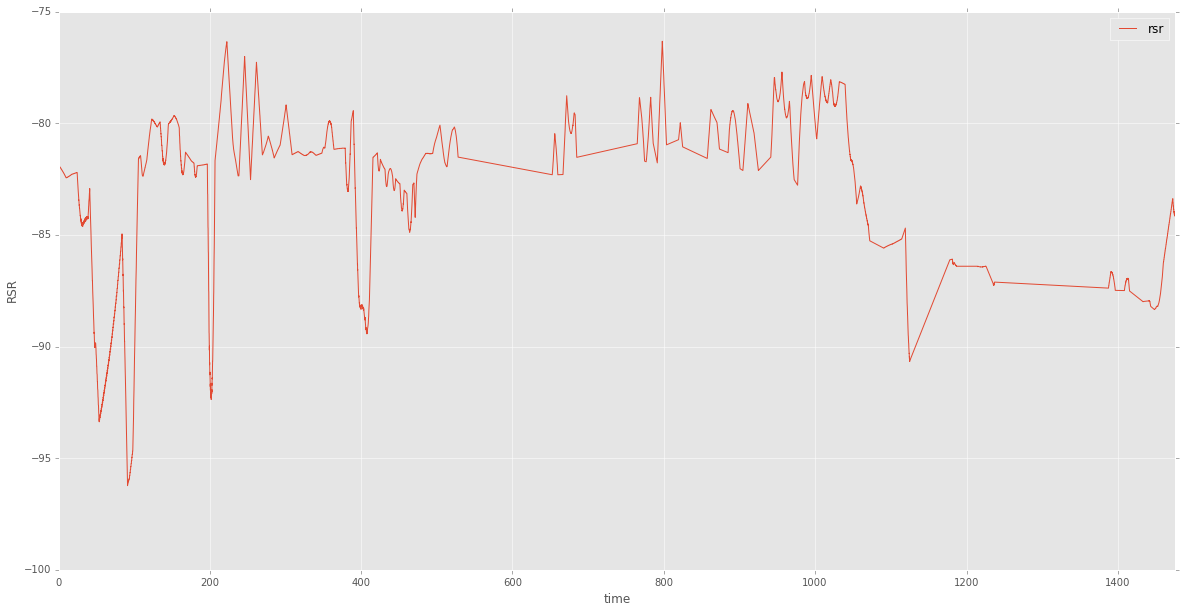

In [32]:
cell_id = 6
signals_long.loc[cell_id].plot(y='rsr'
                              )
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.ylabel('RSR')
plt.xlabel('time')

## Plotting Distance vs RSR

In [53]:
# Picking cell and its RSR
cell_id = 91
cell_ss = signals_long.loc[cell_id].reset_index(drop=False)

# Considering only cases when it is in top-2 of RSR rating
cell_ss = cell_ss[cell_ss.cell_order <= 3]

# Cell info
cell_info = network.loc[cell_id]
user_dist = np.sqrt((user_pos.x - cell_info.x)**2 + (user_pos.y - cell_info.y)**2)

# Considering relevant timestamps
idx = user_pos.time.isin(cell_ss.time)
user_dist = user_dist.ix[idx]

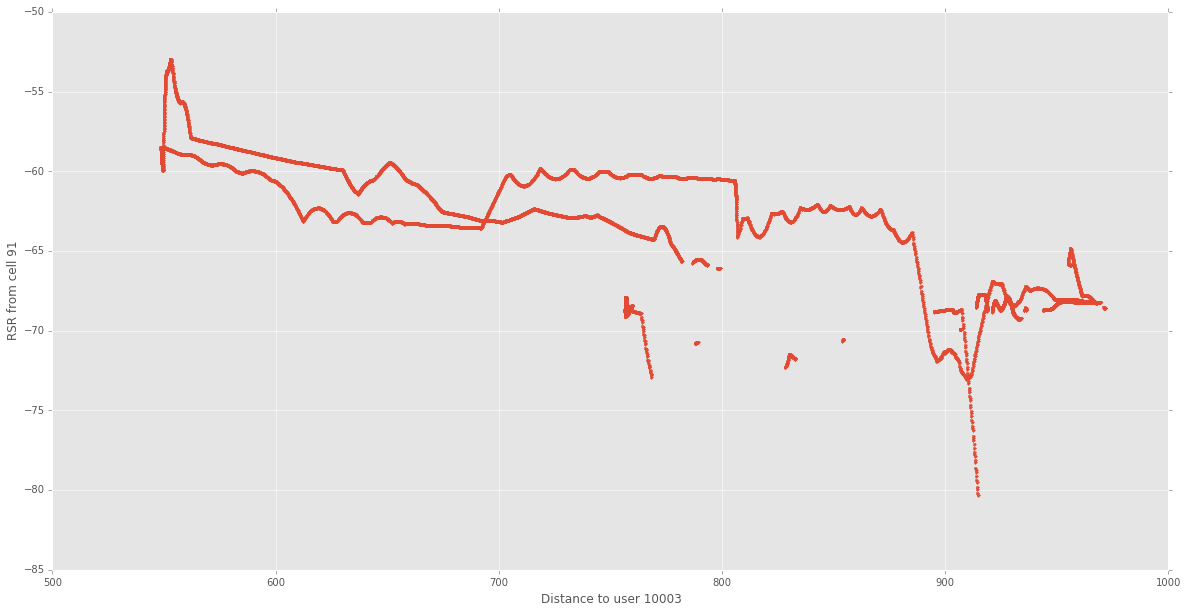

In [54]:
# Plotting

fig = plt.figure(figsize=(20,10))
plt.plot(user_dist, cell_ss.rsr, '.')
plt.xlabel('Distance to user %d' % user_id)
plt.ylabel('RSR from cell %d' % cell_id)
# plt.xlim((200,300))

# k-NN baseline

### Train\test first look

Picking first 1000 users' positions and their rsr <br/>
First 500 going to training set. Others - to test <br/>
Distance measure - cosine distance

In [6]:
# # So slow..
# query = '''SELECT * FROM us_pos INDEXED BY user_index 
#            WHERE userid >= 0 AND userid <= 999;'''

# chunker = pd.read_sql(query, conn, chunksize=10**5)
# df_user_pos = pd.DataFrame()
# for chunk in chunker:
#     df_user_pos = df_user_pos.append(chunk)


# Export to csv is still slow, but import is rather fast..
col_types = {'time': np.dtype(float),
             'userid': np.dtype(int),
             'x': np.dtype(float),
             'y': np.dtype(float)}

df_user_pos = pd.read_csv('./data/uc1004/us_pos_exper.csv', 
                          header=0,
                          dtype=col_types,
                          usecols=col_types.keys())

In [7]:
# I have a strong feeling, that my computer's memory will be overfilled...
df_user_pos.shape

(5435392, 4)

In [8]:
# # So Slow..
# query = '''SELECT * FROM us_signal INDEXED BY user_index_sig 
#            WHERE userid >= 0 AND userid <= 999;'''

# chunker = pd.read_sql(query, conn, chunksize=10**5)
# for chunk in chunker:
#     df_user_rsr = df_user_rsr.append(chunk)
# df_user_rsr.shape

# # Manual transform to long format:
# fout = open('./data/uc1004/us_sig_long.csv', 'w')
# with open('./data/uc1004/us_sig_exper.csv', 'r') as fin:
#     fin.readline() # skip header line
#     fout.write('time,userid,cellid,cell_order,rsr\n')
#     for line in fin:
#         line = line.split(',')
#         time = line[0]
#         userid = line[1]
#         for order in xrange(1,21):
#             cellid = line[2+2*(order-1)]
#             rsr = line[1+2*(order)]
#             fout.write('%s,%s,%s,%s,%s\n' % (time, userid, cellid, order, rsr))
# fout.close()

# # Overflow...
# # Exportin long format
# col_types = {'time': np.dtype(float),
#              'userid': np.dtype(int),
#              'cellid': np.dtype(int),
#              'order': np.dtype(int),
#              'rsr': np.dtype(float)}
    
# df_user_rsr = pd.read_csv('./data/uc1004/us_sig_long.csv', 
#                           header=0,
#                           dtype=col_types)

# The only reasonably fast method and 
# memory-save method
col_types = {'time': np.dtype(float),
             'userid': np.dtype(int)}
for i in xrange(1, 21):
    col_types['cell_id%d' % i] = np.dtype(int)
    col_types['rsr%d' % i] = np.dtype(float)
    
df_user_rsr = pd.read_csv('./data/uc1004/us_sig_exper.csv', 
                          header=0,
                          dtype=col_types)

In [9]:
df_user_rsr.set_index(['userid', 'time'], inplace=True)
df_user_rsr.shape

(5435392, 40)

In [10]:
# Lets look at the roots in train\test
df_user_pos.set_index('userid',  inplace=True)

In [7]:
map_hannover = folium.Map(location=[__CITY_LAT, __CITY_LON], 
                          zoom_start=15)

for index, user_data in df_user_pos.groupby(level=0):
    user_data = add_lat_lon(user_data.reset_index())
    user_data.sort_values('time', inplace=True)
    if index < 500:
        map_hannover.line(locations=user_data[['lat', 'lon']].values,
                          line_opacity=0.2,
                          line_color='blue')
    else: 
        map_hannover.line(locations=user_data[['lat', 'lon']].values,
                          line_opacity=0.2,
                          line_color='red')

# Careful, ~200mb
map_hannover.create_map(path='./data/uc1004/test_train_map.html')

KeyboardInterrupt: 

There is an opinion, that it is better to make random train\test split. According to the map some areas more filled with train, rather than test.

### Building obj-feat matrix

So, for each position we have to build a feature vector, which is an average signal strength for this position from all the cells <br/>
For training set we have to make a grid (1x1 or 2x2 meters)

In [12]:
df_user_pos.reset_index(inplace=True, drop=False)

# ToDo: random train indexing
users_train = np.random.choice(np.arange(1000), 500, replace=False)
idx_train = df_user_pos.userid.isin(users_train)

df_user_pos_train = df_user_pos[idx_train].copy()
df_user_pos_test = df_user_pos[~idx_train].copy()

df_user_pos_train.to_csv('./data/uc1004/train_raw' + __DATE + '.csv')
df_user_pos_test.to_csv('./data/uc1004/test_raw' + __DATE + '.csv')

# # remove floatting point
df_user_pos_train.x = np.around(df_user_pos_train.x, 0)
df_user_pos_train.y = np.around(df_user_pos_train.y, 0)

df_user_pos_train.set_index(['x','y'], inplace=True)
df_user_pos_train.sort_index(inplace=True)

# Helpful stuff
rename_dict = {}
cellidfields = ['cell_id%d'%i for i in xrange(1,21)]
rsrfields = ['rsr%d'%i for i in xrange(1,21)]
for i in xrange(1,21):
    rename_dict['cell_id%d'%i] = 'cell_id'
    rename_dict['rsr%d'%i] = 'rsr'

In [13]:
# Something to init
train_pos_num = len(df_user_pos_train.index.unique())
test_pos_num = df_user_pos_test.shape[0]
pos_train = np.empty((train_pos_num, 2))
pos_test = np.empty((test_pos_num, 2))

cell_num = 195 # actually there are less in the data..

X_train = scipy.sparse.dok_matrix((train_pos_num, cell_num))
X_test = scipy.sparse.dok_matrix((test_pos_num, cell_num))

print train_pos_num
print test_pos_num

359278
2914707


In [27]:
# Filling train matrix
if __LOAD_TRAIN_TEST_MATRIX:
    filename = 'X_train' + __TRAIN_TEST_DATE + '.mm'
    X_train = mmread(os.path.join(__M_FILE_FOLDER, filename))
    filename = 'pos_train' + __TRAIN_TEST_DATE + '.mm'
    pos_train = mmread(os.path.join(__M_FILE_FOLDER, filename))
else:
    ind = 0
    for pos, pos_data in df_user_pos_train.groupby(level=[0,1]):
        pos_train[ind, :] = pos

        idx = zip(pos_data.userid.values, np.round(pos_data.time.values, 1))
        sig_data = df_user_rsr.loc[idx].dropna()

        if sig_data.shape[0]:
            avg = (pd.concat([sig_data[['cell_id%d'%i,'rsr%d'%i]].rename(columns=rename_dict) for i in xrange(1,21)],
                             axis=0, ignore_index=True)
                     .groupby('cell_id')
                     .rsr.agg(np.nanmean))
            X_train[ind, avg.index.values] = avg.values

        ind+=1
        if np.mod(ind, 50000)==0:
            print ind
    filename = 'X_train' + __DATE
    X_train = X_train.tocsr()
    mmwrite(os.path.join(__M_FILE_FOLDER, filename), X_train)
    del X_train
    filename = 'pos_train' + __DATE
    mmwrite(os.path.join(__M_FILE_FOLDER, filename), pos_train)
    del pos_train
    del df_user_pos_train

50000
100000
150000
200000
250000
300000
350000


/home/shestakoff/anaconda/lib/python2.7/site-packages/scipy/sparse/compressed.py:739: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


AttributeError: to_csr not found

In [15]:
# Filling test matrix
# Test matrix sould not be averaged and treated as-is
if __LOAD_TRAIN_TEST_MATRIX:
    filename = 'X_test' + __TRAIN_TEST_DATE + '.mm'
    X_test = mmread(os.path.join(__M_FILE_FOLDER, filename))
    filename = 'pos_test' + __TRAIN_TEST_DATE + '.mm'
    pos_test = mmread(os.path.join(__M_FILE_FOLDER, filename))
else:
    ind = 0
    ind_matrix = 0
    idxrow = np.empty((df_user_pos_test.shape[0]*20,))
    idxcol = np.empty((df_user_pos_test.shape[0]*20,))
    idxvals = np.empty((df_user_pos_test.shape[0]*20,))
    for index, pos_data in df_user_pos_test.groupby('userid'):
        pos_test[ind:(ind+pos_data.shape[0]), :] = pos_data[['x','y']].values
        
        mrg = pd.merge(pos_data, df_user_rsr, left_on=['userid', 'time'], right_index=True)
        
        idxrow[ind_matrix:(ind_matrix+pos_data.shape[0]*20)] = np.array(range(ind,(ind+pos_data.shape[0]))*20).flatten()
        idxcol[ind_matrix:(ind_matrix+pos_data.shape[0]*20)] = mrg[cellidfields].values.T.flatten()
        
        idxvals[ind_matrix:(ind_matrix+pos_data.shape[0]*20)] = mrg[rsrfields].values.T.flatten()

        ind+=pos_data.shape[0]
        ind_matrix+=pos_data.shape[0]*20
        print ind  

    
    filename = 'pos_test' + __DATE
    mmwrite(os.path.join(__M_FILE_FOLDER, filename), pos_test)
    filename = 'idxrow' + __DATE
    mmwrite(os.path.join(__M_FILE_FOLDER, filename), idxrow)
    filename = 'idxcol' + __DATE
    mmwrite(os.path.join(__M_FILE_FOLDER, filename), idxcol)
    filename = 'idxvals' + __DATE
    mmwrite(os.path.join(__M_FILE_FOLDER, filename), idxvals)
    
    # cleaning before knn
    del df_user_rsr
    del df_user_pos

2722
8827
17503
18698
21326
32214
35507
36084
66704
67407
79472
82197
85187
89404
89511
92137
93013
118439
126297
131591
135735
139117
147608
152549
152569
153362
160166
160301
160584
161834
175768
176894
181425
185843
197834
200887
204990
210357
214516
229072
236851
261742
268190
276525
285963
286792
294619
296337
318353
324686
327393
342455
354260
358882
373695
374611
378627
380647
393144
396370
410799
418797
423339
425341
461341
463666
466176
471817
477721
481394
495075
503019
504097
510332
512296
517191
553191
561835
561884
562339
581131
585226
585428
586145
594889
595583
596367
596537
599583
601229
602025
604792
604857
606025
609079
612803
613543
616654
617861
621069
626191
626469
628645
658323
667733
669684
701823
706322
719178
720582
726541
728951
729239
729410
730181
730899
734082
743259
744139
744908
748240
749127
749700
754601
757343
759957
760413
762293
766443
772110
772313
787246
793270
796775
798690
800468
804041
806733
814791
817738
824003
824807
827702
834555
836756
8386

ValueError: Expected 2 dimensional array

In [23]:
X_test = (scipy.sparse
               .coo_matrix((idxvals, (idxrow,idxcol)),
                          shape=(df_user_pos_test.shape[0], cell_num)))
X_test = X_test.tocsr()
filename = 'X_test' + __DATE
mmwrite(os.path.join(__M_FILE_FOLDER, filename), X_test)

## KNN itself

Ok, there was some error, lets look at least to what we have

In [5]:
X_train = mmread('./data/uc1004/mmfiles/X_train_2015-12-22_02_25_57.mtx')
X_train = X_train.tocsr()
pos_train = mmread('./data/uc1004/mmfiles/pos_train_2015-12-22_02_25_57.mtx')
X_test = mmread('./data/uc1004/mmfiles/X_test_2015-12-22_02_25_57.mtx')
X_test = X_test.tocsr()
pos_test = mmread('./data/uc1004/mmfiles/pos_test_2015-12-22_02_25_57.mtx')

In [6]:
# Sklearn KN

# cosine
knn = KNeighborsRegressor(n_neighbors=1, algorithm='brute', 
                          metric='cosine', n_jobs=2)

# # euclidean
# knn = KNeighborsRegressor(n_neighbors=1, algorithm='auto', 
#                           metric='euclidean', n_jobs=1)

knn.fit(X_train, pos_train)
pos_pred = np.empty_like(pos_test)

In [ ]:
knn

KNeighborsRegressor(algorithm='brute', leaf_size=30, metric='cosine',
          metric_params=None, n_jobs=2, n_neighbors=1, p=2,
          weights='uniform')

In [ ]:
# Not to overfill memory..
istep = 400
for i in xrange(istep, pos_pred.shape[0], istep):
    pos_pred[(i-istep):i] = knn.predict(X_test[(i-istep):i, :])

if i < pos_pred.shape[0]:
    pos_pred[i:] = knn.predict(X_test[i:, :])

In [ ]:
__DATE = '_2015-12-22_02_25_57'
filename = 'pos_pred_cosine' + __DATE
mmwrite(os.path.join(__M_FILE_FOLDER, filename), pos_pred)

## Estimate accuracy

In [2]:
pos_pred = mmread('./data/uc1004/mmfiles/pos_pred_2015-12-22_02_25_57.mtx')
pos_test = mmread('./data/uc1004/mmfiles/pos_test_2015-12-22_02_25_57.mtx')

In [3]:
err = np.sqrt(((pos_pred - pos_test)**2).sum(axis=1))

In [10]:
np.percentile(err, 67)

0.52201532544542295

In [7]:
bs_mean(err, 10000, 95)

array([ 0.0728011 ,  4.69204827])

In [ ]:
# possible reason for big error - zero rows in train\test

# Trying to find some bug

In [44]:
cellidfields = ['cell_id%d'%i for i in xrange(1,21)]
rsrfields = ['rsr%d'%i for i in xrange(1,21)]

In [ ]:
X_train = mmread('./data/uc1004/mmfiles/X_train_2015-12-22_02_25_57.mtx')
X_train = X_train.tocsr()
pos_train = mmread('./data/uc1004/mmfiles/pos_train_2015-12-22_02_25_57.mtx')
X_test = mmread('./data/uc1004/mmfiles/X_test_2015-12-22_02_25_57.mtx')
X_test = X_test.tocsr()
pos_test = mmread('./data/uc1004/mmfiles/pos_test_2015-12-22_02_25_57.mtx')
pos_pred = mmread('./data/uc1004/mmfiles/pos_pred_cosine_2015-12-22_02_25_57.mtx')

In [ ]:
df_user_rsr = pd.read_csv('./data/uc1004/us_sig_exper.csv', 
                          header=0,
                          dtype=col_types)
df_user_pos_train = pd.read_csv('./data/uc1004/train_raw_2015-12-22_02_25_57.csv')
df_user_pos_test = pd.read_csv('./data/uc1004/test_raw_2015-12-22_02_25_57.csv')

In [37]:
df_user_pos_test.head(6)

,Unnamed: 0,userid,time,x,y
0,3307,1,0.1,9893.95,13653.38
1,3308,1,0.2,9893.95,13653.38
2,3309,1,0.3,9893.95,13653.38
3,3310,1,0.4,9893.95,13653.38
4,3311,1,0.5,9893.95,13653.38
5,3312,1,0.6,9893.95,13653.37


In [56]:
df_user_rsr.loc[1].head()

,cell_id1,rsr1,cell_id2,rsr2,cell_id3,rsr3,cell_id4,rsr4,cell_id5,rsr5,...,cell_id16,rsr16,cell_id17,rsr17,cell_id18,rsr18,cell_id19,rsr19,cell_id20,rsr20
time,,,,,,,,,,,,,,,,,,,,,
0.1,31,-49.11,27,-51.14,88,-63.21,25,-63.78,135,-65.65,...,91,-77.62,187,-77.92,33,-78.18,15,-78.56,152,-79.62
0.2,31,-49.11,27,-51.14,88,-63.21,25,-63.78,135,-65.65,...,91,-77.62,187,-77.92,33,-78.18,15,-78.56,152,-79.62
0.3,31,-49.11,27,-51.14,88,-63.21,25,-63.78,135,-65.65,...,91,-77.62,187,-77.92,33,-78.18,15,-78.56,152,-79.62
0.4,31,-49.11,27,-51.14,88,-63.21,25,-63.78,135,-65.65,...,91,-77.62,187,-77.92,33,-78.18,15,-78.56,152,-79.62
0.5,31,-49.11,27,-51.14,88,-63.21,25,-63.78,135,-65.65,...,91,-77.62,187,-77.92,33,-78.18,15,-78.56,152,-79.62


In [19]:
pos_test[:6,:]

array([[  9893.95,  13653.38],
       [  9893.95,  13653.38],
       [  9893.95,  13653.38],
       [  9893.95,  13653.38],
       [  9893.95,  13653.38],
       [  9893.95,  13653.37]])

Checking that test matrix is properly constructed

In [57]:
# Checking test matrix
print X_test[8,:].sum()

cur_rsr = df_user_rsr.loc[1, 0.8]
print cur_rsr[rsrfields].sum()

-1395.1
-1395.1


It seems that everything is allright with the test matrix, in sense it is properly constructed..

In [72]:
np.unique(X_train.getnnz(axis=1))

array([20, 21, 22, 23], dtype=int32)

Here it is also good..

In [92]:
np.unique(pos_pred)

array([ -1.18330000e+02,  -1.18290000e+02,  -1.18240000e+02, ...,
         1.89794700e+06,   1.89794800e+06,   1.89794900e+06])

In [94]:
np.unique(pos_pred)

array([  8500.,  11007.])

got you, bitch!

In [84]:
knn.predict(X_test[1, :])

array([[  9894.,  13653.]])

In [95]:
istep = 10
i = 10
knn.predict(X_test[(i-istep):i, :])

array([[  9894.,  13653.],
       [  9894.,  13653.],
       [  9894.,  13653.],
       [  9894.,  13653.],
       [  9894.,  13653.],
       [  9894.,  13653.],
       [  9894.,  13653.],
       [  9894.,  13653.],
       [  9894.,  13653.],
       [  9894.,  13653.]])

In [105]:
a = range(1000000, pos_pred.shape[0], 1000000)

In [106]:
a

[1000000, 2000000]